# Environment preparations

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Prepare dataset
!cp -r /content/drive/MyDrive/dataset /content/
!cp -r /content/drive/MyDrive/HW2 /content/
!cp -r /content/drive/MyDrive/outputs /content/
!unzip dataset/models.zip -d ./
!unzip dataset/testing_data_pose.zip -d ./
!unzip dataset/training_data.zip -d ./



流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: ./training_data_filtered/training_data/v2.2/1-6-0_meta.pkl  
  inflating: ./training_data_filtered/training_data/v2.2/2-168-12_label_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/2-29-2_color_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/1-84-0_meta.pkl  
  inflating: ./training_data_filtered/training_data/v2.2/2-213-38_meta.pkl  
  inflating: ./training_data_filtered/training_data/v2.2/2-209-30_color_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/2-45-9_meta.pkl  
  inflating: ./training_data_filtered/training_data/v2.2/2-35-17_color_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/1-47-1_label_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/1-54-6_depth_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/2-28-34_depth_kinect.png  
  inflating: ./training_data_filtered/training_data/v2.2/1-53-1_meta.pkl  
  inflatin

# Training data Loading

In [ ]:
!pip install utils
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.2
    Uninstalling nbformat-5.9.2:
      Successfully uninstalled nb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import utils

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)



In [ ]:
training_data_root = "./training_data_filtered/training_data"
training_data_dir = "./training_data_filtered/training_data/v2.2"
split_dir = "./training_data_filtered/training_data/splits/v2"


In [ ]:
"""Visualization utilies."""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def show_points(points, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points[:, 0], points[:, 2], points[:, 1])

def compare_points(points1, points2):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points1[:, 0], points1[:, 2], points1[:, 1])
    ax.scatter(points2[:, 0], points2[:, 2], points2[:, 1])

In [ ]:
"""Metric and visualization."""

def compute_rre(R_est: np.ndarray, R_gt: np.ndarray):
    """Compute the relative rotation error (geodesic distance of rotation)."""
    assert R_est.shape == (3, 3), 'R_est: expected shape (3, 3), received shape {}.'.format(R_est.shape)
    assert R_gt.shape == (3, 3), 'R_gt: expected shape (3, 3), received shape {}.'.format(R_gt.shape)
    # relative rotation error (RRE)
    # Rotational degree loss (not objective of optimization)
    rre = np.arccos(np.clip(0.5 * (np.trace(R_est.T @ R_gt) - 1), -1.0, 1.0))
    return rre


def compute_rte(t_est: np.ndarray, t_gt: np.ndarray):
    assert t_est.shape == (3,), 't_est: expected shape (3,), received shape {}.'.format(t_est.shape)
    assert t_gt.shape == (3,), 't_gt: expected shape (3,), received shape {}.'.format(t_gt.shape)
    # relative translation error (RTE)
    rte = np.linalg.norm(t_est - t_gt) # Resembling MSE loss
    return rte




In [ ]:
def get_train_split_files(split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefixIds = [line.strip() for line in f if line.strip()]
        prefix = [os.path.join(training_data_dir, line) for line in prefixIds]
        # prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta, prefixIds


[35 39 48 51 58]
['jenga', 'master_chef_can', 'potted_meat_can', 'pudding_box', 'wood_block']
./training_data_filtered/training_data/v2.2/1-1-4_label_kinect.png
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, array([1., 1., 1.], dtype=float32), None, None, None, array([0.5, 0.5, 0.5], dtype=float32), None, None, None, None, None, None, None, None, array([1., 1., 1.], dtype=float32), None, None, array([0.5, 0.5, 0.5], dtype=float32), None, None, None, None, None, None, array([0.5, 0.5, 0.5], dtype=float32), None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
dict_keys(['poses_world', 'extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])
[0.778 0.778 0.778 ... 0.71  0.708 0.709]
(720, 1280, 3)
(4417, 3)
(4417, 3)


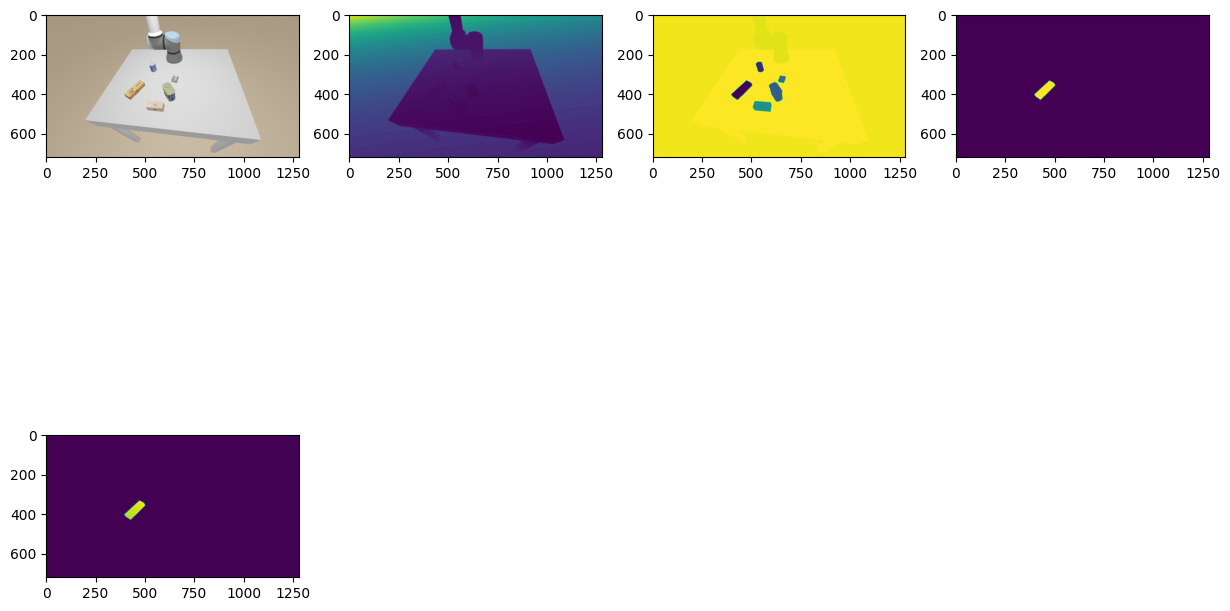

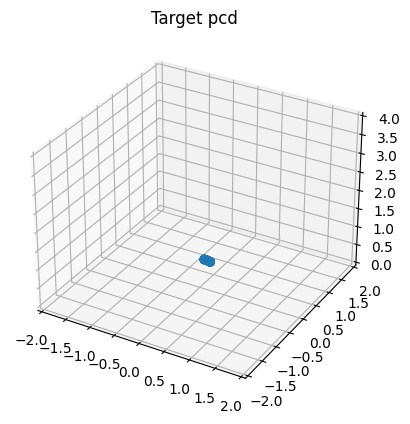

In [ ]:
import numpy as np


def get_point_cloud(depth, intrinsic):
  z = depth
  v, u = np.indices(z.shape)
  uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
  points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
  return points_viewer

def get_object_point_cloud(test_image_label, object_id, test_depth, intrinsic):
  test_image_label[np.where(test_image_label==object_id)] = 255
  test_image_label[np.where(test_image_label!=255)] = 0
  test_image_label[np.where(test_image_label==255)] = 1
  test_object_depth = test_depth * test_image_label
  test_pcd_target = get_point_cloud(test_object_depth, intrinsic)
  test_pcd_target = test_pcd_target.reshape(-1, test_pcd_target.shape[-1]) # reshape to (H*W, 3)
  test_pcd_target = test_pcd_target[(test_pcd_target[:,0]!=0)|(test_pcd_target[:,1]!=0)|(test_pcd_target[:,2]!=0)]
  return test_pcd_target


rgb_files, depth_files, label_files, meta_files, prefix_ids = get_train_split_files('val')
# rgb_files: RGB color maps
# depth_files: Depth map
# label_files: Segmentation mask
# meta_files: Pose. Extrinsics. Intrinsics
rgb = np.array(Image.open(rgb_files[0])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[0])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[0]))
meta = load_pickle(meta_files[0])
ids, names, intrinsic, scales = meta["object_ids"], meta["object_names"], meta["intrinsic"], meta["scales"]
print(ids)
print(names)
print(label_files[0])
print(scales)
plt.figure(figsize=(15, 10))
plt.subplot(2, 4, 1)
plt.imshow(rgb)
plt.subplot(2, 4, 2)
plt.imshow(depth)
plt.subplot(2, 4, 3)
plt.imshow(label)  # draw colorful segmentation
print(meta.keys())
a=rgb.reshape(-1, rgb.shape[-1])
object_id = 35
label[np.where(label==object_id)] = 255
label[np.where(label!=255)] = 0
label[np.where(label==255)] = 1
plt.subplot(2, 4, 4)
plt.imshow(label)
depth = depth * label
plt.subplot(2, 4, 5)
plt.imshow(depth)
print(depth[depth!=0])
pcd = get_point_cloud(depth, intrinsic)
print(pcd.shape)
pcd = pcd.reshape(-1, pcd.shape[-1]) # reshape to (H*W, 3)
pcd = pcd[(pcd[:,0]!=0)|(pcd[:,1]!=0)|(pcd[:,2]!=0)]
print(pcd.shape)
pcd = pcd * scales[object_id]
print(pcd.shape)
show_points(pcd, "Target pcd")



In [ ]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

<ipython-input-12-80c26a906e79>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('rainbow', NUM_OBJECTS)


# Testing data loading

In [ ]:
test_split_dir = "./testing_data_pose_filtered/testing_data"
testing_data_root = "./testing_data_pose_filtered/testing_data"
testing_data_dir = "./testing_data_pose_filtered/testing_data/v2.2"

def get_test_split_files(split_name):
    with open(os.path.join(test_split_dir, f"{split_name}.txt"), 'r') as f:
        prefixIds = [line.strip() for line in f if line.strip()]
        prefix = [os.path.join(testing_data_dir, line) for line in prefixIds]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta, prefixIds

In [ ]:
test_rgb_files, test_depth_files, test_label_files, test_meta_files, test_prefix_ids = get_test_split_files('test')
test_size = len(test_rgb_files)
test_meta = load_pickle(test_meta_files[0])
print(test_meta.keys())
print(test_size)
print(test_prefix_ids)

dict_keys(['extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])
200
['1-1-1', '1-2-1', '1-3-1', '1-4-1', '1-5-1', '1-6-1', '1-7-1', '1-8-1', '1-9-1', '1-10-1', '1-11-1', '1-12-1', '1-13-1', '1-14-1', '1-15-1', '1-16-1', '1-17-1', '1-18-1', '1-19-1', '1-20-1', '1-21-1', '1-22-1', '1-23-1', '1-24-1', '1-25-1', '1-26-1', '1-27-1', '1-28-1', '1-29-1', '1-30-1', '1-31-1', '1-32-1', '1-33-1', '1-34-1', '1-35-1', '1-36-1', '1-37-1', '1-38-1', '1-39-1', '1-40-1', '1-41-1', '1-42-1', '1-43-1', '1-44-1', '1-45-1', '1-46-1', '1-47-1', '1-48-1', '1-49-1', '1-50-1', '1-51-1', '1-52-1', '1-53-1', '1-54-1', '1-55-1', '1-56-1', '1-57-1', '1-58-1', '1-59-1', '1-60-1', '1-61-1', '1-62-1', '1-63-1', '1-64-1', '1-65-1', '1-66-1', '1-67-1', '1-68-1', '1-69-1', '1-70-1', '1-71-1', '1-72-1', '1-73-1', '1-74-1', '1-75-1', '1-76-1', '1-77-1', '1-78-1', '1-79-1', '1-80-1', '1-81-1', '1-82-1', '1-83-1', '1-84-1', '1-85-1', '1-86-1', '1-87-1', '1-88-1', '1-89-1', '1-90-1', '1-91-1', '1-92

# ICP implementation

In [ ]:
"""ICP implementation"""
import open3d as o3d
from tqdm import tqdm
import numpy as np
from sklearn.neighbors import NearestNeighbors


def oneNN(source_pcd, target_pcd):
    '''
    Map source_pcd to nearest neighbour in target_pcd
    Input:
        source_pcd: Nx3 array of points
        target_pcd: Nx3 array of points
    Output:
        dists: Euclidean distances of the nearest neighbor
        inds: target_pcd indices of the nearest neighbor
    '''
    # Get Nearest-Neighbours of source and target point clouds
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(target_pcd)
    dists, inds = neigh.kneighbors(source_pcd, return_distance=True)
    return dists.ravel(), inds.ravel()



def getRT(source_pcd, target_pcd):
    """
    Get R, t, given source pcd and aligned target pcd
    """
    # Get R, t (by Umeyama's minimization of distance)
    N = source_pcd.shape[0]
    qbar = np.mean(target_pcd, axis=0)
    pbar = np.mean(source_pcd, axis=0)
    M = (target_pcd-qbar).T @ (source_pcd-pbar)
    U, D, VT = np.linalg.svd(M)

    R = U @ VT
    if (np.linalg.det(R)<0):
        VT[-1,:] *= -1
        R = U @ VT

    t = qbar - (R @ pbar)
    return R, t

def icp(source_pcd, target_pcd, steps=50):
    """Iterative closest point.

    Args:
        source_pcd (np.ndarray): [N1, 3]
        target_pcd (np.ndarray): [N2, 3]

    Returns:
        np.ndarray: [4, 4] rigid transformation to align source to target.
    """
    # Self-implemented ICP
    T = np.eye(4)
    R, t = np.eye(3), np.zeros(3)
    N = source_pcd.shape[0]
    source_pcd_cp = source_pcd.copy()

    # Implement your own algorithm here.
    nsteps = steps
    for i in tqdm(range(nsteps)):
        # Update correspondance (by re-aligning target)
        distances, indices = oneNN(source_pcd, target_pcd)
        # Umayama's algo for getting R, t
        R, t = getRT(source_pcd, target_pcd[indices, :])
        source_pcd = source_pcd @ R.T + t

    R, t = getRT(source_pcd_cp, source_pcd)
    T[:3, :3], T[:3, -1] = R, t
    # print("Final T:")
    # print(T)
    # print(T.tolist())
    return T


def get_o3d_icp(source_pcd, target_pcd):
  # ICP using Open3D
  source_pcd_o3d, target_pcd_o3d = o3d.geometry.PointCloud(), o3d.geometry.PointCloud()
  source_pcd_o3d.points = o3d.utility.Vector3dVector(source_pcd)
  target_pcd_o3d.points = o3d.utility.Vector3dVector(target_pcd)
  init = np.eye(4)
  T = o3d.pipelines.registration.registration_icp( \
        source_pcd_o3d, target_pcd_o3d, 5, init, \
        o3d.pipelines.registration.TransformationEstimationPointToPoint(), \
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.00000001, \
                                 relative_rmse=0.00000001, \
                                 max_iteration=500))
  T = T.transformation
  return T


# Loading object model

---



In [ ]:
!pip install trimesh
!pip install pycollada

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.5/688.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 918.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycollada: filename=pycollada-0.7.2-py3-none-any.whl size=127017 sha256=b1d7d8bfe0479f26e74bd40fe1073b6c9cd0d9faa47a26c8316544af5d8323a9
  Stored in directory: /root/.cache/pip/wheels/d5/ba/33/1e99a7e7defd1d77f0210e7a39ff58de2a2d8d4c22466bb2da
Successfully built pycollada


In [ ]:
# Load the canonical-space object point clouds
import trimesh
import collada
import os
import pandas as pd

def fps_downsample(points, number_of_points_to_sample):
  selected_points = np.zeros((number_of_points_to_sample, 3))
  dist = np.ones(points.shape[0]) * np.inf # distance to the selected set
  for i in tqdm(range(number_of_points_to_sample)):
      # pick the point with max dist
      idx = np.argmax(dist)
      selected_points[i] = points[idx]
      dist_ = ((points - selected_points[i]) ** 2).sum(-1)
      dist = np.minimum(dist, dist_)
  return selected_points

object_models_file = os.path.join(training_data_root, "objects_v1.csv")
object_models_info = pd.read_csv(object_models_file)
object_models_name = object_models_info["object"].to_list()
object_models_location = object_models_info["location"].to_list()
object_models_num = len(object_models_name)


object_models = {}
for object_name, object_mesh_dir in zip(object_models_name, object_models_location):
  object_mesh_path = os.path.join(object_mesh_dir, "visual_meshes", "visual.dae")
  object_mesh = trimesh.exchange.dae.load_collada(object_mesh_path)
  mesh_name = object_mesh['graph'][0]['geometry']
  object_models[object_name] = object_mesh['geometry'][mesh_name]['vertices']







# ICP-based Pose Estimation on test data

In [ ]:
"""Definitions of hyper-parameters"""
icp_global_voxel_size = 0.03
icp_dist_threshold = 5
init_random_time = 150
max_preproc_nn_normal = 50
max_preproc_nn_fpfh = 100
tgSrcFactor = 1.3
dist_voxel_factor = 3
fps_dnsamp_factor = 2000
geodDistFrac = 0.3
cdistFrac = 0.1
heavy_dnsamp_frac = 9/14
# heavy_dnsamp_frac = 1/2 # exp 7
# heavy_dnsamp_frac = 5/14 # exp 8
icp_relative_fitness = 0.00001
icp_relative_rmse = 0.00001
icp_max_iteration = 500
light_heavy_dnsamp_vxsize_ratio = 0.001
# light_heavy_dnsamp_vxsize_ratio = 0.1
ransac_max_iteration = 10000000
ransac_max_validation = 0.99999


In [ ]:
import numpy as np
import json

# Helper function for the reconstruction of the target point cloud
def load_pickle(filename):
  with open(filename, 'rb') as f:
    return pickle.load(f)

def dump_json(sample, path):
  with open(path, 'w') as fp:
    json.dump(sample, fp)
  return 0

def load_json(path):
  f = open(path)
  data = json.load(f)
  return data

def get_point_cloud(depth, intrinsic):
  z = depth
  v, u = np.indices(z.shape)
  uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
  points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
  return points_viewer

def get_object_point_cloud(test_image_label, object_id, test_depth, intrinsic):
  # Reconstruct target pcd based on image and depth maps
  test_image_label[np.where(test_image_label==object_id)] = 255
  test_image_label[np.where(test_image_label!=255)] = 0
  test_image_label[np.where(test_image_label==255)] = 1
  test_object_depth = test_depth * test_image_label
  test_pcd_target = get_point_cloud(test_object_depth, intrinsic)
  # filter out target object point cloud
  test_pcd_target = test_pcd_target.reshape(-1, test_pcd_target.shape[-1]) # reshape to (H*W, 3)
  test_pcd_target = test_pcd_target[(test_pcd_target[:,0]!=0)|(test_pcd_target[:,1]!=0)|(test_pcd_target[:,2]!=0)]
  return test_pcd_target

def get_meta(meta_path):
  return load_pickle(meta_path)

def get_depth(depth_path):
  return (np.array(Image.open(depth_path))/1000)

def get_label(label_path):
  return np.array(Image.open(label_path))

def getTransPcd(source_pcd, T):
  return source_pcd @ T[:3, :3].T + T[:3, 3]

def getRotationGeoDist(r, rgt):
  return np.arccos(1/2 * (np.trace(rgt @ r.T) - 1))

def getTranslationDist(t, tgt):
  return np.norm(t-tgt)

def o3dvis(pts):
  o3d.visualization.draw_geometries([pts_to_o3d_pcd(pt) for pt in pts])
  return 0

def pts_to_o3d_pcd(pts):
  """Transform to o3d pcd"""
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(pts)
  return pcd

def o3d_Vec_to_o3d_pcd(pts):
  """Transform to o3d pcd"""
  pcd = o3d.geometry.PointCloud()
  pcd.points = pts
  return pcd

def normalization(data):
    """Normalize data"""
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

def standardization(data):
    """Standarize data"""
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / (sigma + 1.0e-16)


In [ ]:
import copy

def get_o3d_icp(source_pcd, target_pcd, init=np.eye(4), icp_dist_threshold=icp_dist_threshold,
                icp_relative_fitness=icp_relative_fitness,
                icp_relative_rmse=icp_relative_rmse,
                icp_max_iteration=icp_max_iteration):
  # ICP based on Open3D implementations
  source_pcd_o3d, target_pcd_o3d = o3d.geometry.PointCloud(), o3d.geometry.PointCloud()
  source_pcd_o3d.points = o3d.utility.Vector3dVector(source_pcd)
  target_pcd_o3d.points = o3d.utility.Vector3dVector(target_pcd)
  T = o3d.pipelines.registration.registration_icp( \
        source_pcd_o3d, target_pcd_o3d, icp_dist_threshold, init, \
        o3d.pipelines.registration.TransformationEstimationPointToPoint(), \
        # o3d.pipelines.registration.TransformationEstimationPointToPlane(), \
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=icp_relative_fitness, \
                                 relative_rmse=icp_relative_rmse, \
                                 max_iteration=icp_max_iteration))
  return T

def half_voxel_dnsample(source, voxel_size, heavy_dnsamp_frac=heavy_dnsamp_frac,
                        light_heavy_dnsamp_vxsize_ratio=light_heavy_dnsamp_vxsize_ratio):
  # Heavy-mild voxel down-sampling implementations
  pts = source.points
  size = len(pts)
  first_half = o3d_Vec_to_o3d_pcd(pts[:int(size*heavy_dnsamp_frac)])
  first_half = first_half.voxel_down_sample(voxel_size=voxel_size) # heavily down-sampled side
  secn_half = o3d_Vec_to_o3d_pcd(pts[int(size*heavy_dnsamp_frac):])
  if (light_heavy_dnsamp_vxsize_ratio != 0):
    secn_half = secn_half.voxel_down_sample(voxel_size=voxel_size*light_heavy_dnsamp_vxsize_ratio) # weakly down-sampled side

  first_half_pts = np.asarray(first_half.points)
  secn_half_pts = np.asarray(secn_half.points)
  full_pcd_pts = np.vstack((first_half_pts, secn_half_pts))
  full_pcd_pts = pts_to_o3d_pcd(full_pcd_pts)
  return full_pcd_pts

def preprocess_point_cloud(source, target, voxel_size, max_nn_normal=max_preproc_nn_normal,
              max_nn_fpfh=max_preproc_nn_fpfh, tgSrcFactor=tgSrcFactor, fps_dnsamp_factor=fps_dnsamp_factor):
    # Compute FPFH features and down-sample the pcds
    size_factor = len(source.points) / len(target.points)
    if (size_factor >= 1): # Heavy-mild voxel down-sampling
      src_pcd_down = half_voxel_dnsample(source, voxel_size=voxel_size)
    else:
      src_pcd_down = source
    tg_pcd_down = target
    radius_normal = voxel_size * 2
    src_pcd_down.estimate_normals( # FPFH features' computations (for global registration preparations)
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=max_nn_normal))
    radius_feature = voxel_size * 5
    src_pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        src_pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=max_nn_fpfh))
    tg_pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=max_nn_normal))
    tg_pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        tg_pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=max_nn_fpfh))

    return src_pcd_down, src_pcd_fpfh, tg_pcd_down, tg_pcd_fpfh

def prepare_dataset(voxel_size, source, target):
    source_down, source_fpfh, target_down, target_fpfh = preprocess_point_cloud(source, target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size, dist_voxel_factor=dist_voxel_factor,
                                ransac_max_iteration=ransac_max_iteration,
                                ransac_max_validation=ransac_max_validation):
  # Execute RANSAC global registrations
  distance_threshold = voxel_size * dist_voxel_factor
  result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
      source_down, target_down, source_fpfh, target_fpfh, True,
      distance_threshold,
      o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
      3, [
          o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
              0.9),
          o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
              distance_threshold)
      ], o3d.pipelines.registration.RANSACConvergenceCriteria(ransac_max_iteration, ransac_max_validation))
  return result



def get_o3d_icp_with_global_registration(source_pcd, target_pcd, voxel_size=icp_global_voxel_size,
                      init_random_time=init_random_time,
                      cdistFrac=cdistFrac):
  source_pcd_o3d, target_pcd_o3d = o3d.geometry.PointCloud(), o3d.geometry.PointCloud()
  source_pcd_o3d.points = o3d.utility.Vector3dVector(source_pcd)
  target_pcd_o3d.points = o3d.utility.Vector3dVector(target_pcd)
  source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(voxel_size, source_pcd_o3d, target_pcd_o3d)

  # perform multiple RANSAC inits, and choose the best amongest them
  Trans, rmse, cdists, rotDists, transDists = [], [], [], [], []
  for i in tqdm(range(init_random_time)):
    result_ransac = execute_global_registration(source_down, target_down, \
                      source_fpfh, target_fpfh, \
                      voxel_size)
    result_icp = get_o3d_icp(source_down.points, target_down.points, init=result_ransac.transformation)
    tr = result_icp.transformation
    trans_source_down = copy.deepcopy(source_down)
    trans_source_down = trans_source_down.transform(tr)
    dists = target_down.compute_point_cloud_distance(trans_source_down)
    dists = np.asarray(dists)
    Trans.append(tr) # Record the transformation
    rmse.append(result_icp.inlier_rmse) # Record point-wise RMSE
    cdists.append(np.sum(dists)) # Record chamfer distance
  cdistsNorm = standardization(np.array(cdists)) # normalize losses
  rmseNorm = standardization(np.array(rmse))
  
  # Choose the best transformation with minimal overall shape-aware loss
  # optim_index = np.argmin((1-cdistFrac)*rmseNorm+cdistFrac*cdistsNorm) 
  return Trans[np.argmin((1-cdistFrac)*rmseNorm+cdistFrac*cdistsNorm)]


# ICP-based Pose Estimation on test data (continual estimation)

In [ ]:
# Start ICP estimation for test data, continuing from some epoch (previous one cannot continue from some epoch)
# !mkdir test_outputs
import numpy as np
from tqdm import tqdm
import os

# Flag for continuing from previous steps
ctu = True
ctu_variant, ctu_index = 0, 0
if ctu:
  ctu_variant, ctu_index = "2-20-1", 119

# Output resulting dictionary
dataset_type = "test"
output_dir = "./{}_outputs_8".format(dataset_type)

# For each object at each testing data: Get scene object's point cloud (as target pcd)
result_dict = {}
if ctu:
  json_path = os.path.join(output_dir, "result_till_{}_index_{}.json".format(ctu_variant, ctu_index))
  result_dict = load_json(json_path)
print(test_depth_files)
print(test_meta_files)
print(test_label_files)
print(test_prefix_ids)

for i in range(ctu_index, test_size):
  if (i % 10 == 0):
    print("Auto-uploading test outputs to cloud at epoch {}".format(i))
  test_depth_path, test_meta_path, test_label_path, test_prefix_id = test_depth_files[i], test_meta_files[i], test_label_files[i], test_prefix_ids[i]
  print("Test data id {}".format(test_prefix_id))
  test_meta, test_depth, test_seg_label = get_meta(test_meta_path), get_depth(test_depth_path), get_label(test_label_path)   # convert from mm to m
  intrinsic = test_meta["intrinsic"]
  extrinsic = test_meta["extrinsic"]
  inv_extrinsic = np.linalg.inv(extrinsic)
  scales = test_meta["scales"]
  result_dict[test_prefix_id] = {}
  result_dict[test_prefix_id]["poses_world"] = [None] * object_models_num
  for object_id, object_name in zip(test_meta["object_ids"], test_meta["object_names"]):
    print("Object id {}, name {}".format(object_id, object_name))
    
    # mask the object's depth map to get test_object_depth
    if (np.sum(test_seg_label==object_id) == 0):
      print("Object not found at scene.")
      continue
    test_image_label = test_seg_label.copy()

    # mask the object's depth map to get test_object_depth
    test_pcd_target = get_object_point_cloud(test_image_label, object_id, test_depth, intrinsic)

    # Fetch source point cloud from model dictionary
    test_pcd_source = object_models[object_name]
    test_pcd_source *= scales[object_id] # scale the model pcd using factors
    # print(test_pcd_source.shape)
    # print(test_pcd_target.shape)

    # ICP to get posture
    T = get_o3d_icp_with_global_registration(test_pcd_source, test_pcd_target)
    T_world = inv_extrinsic @ T # Transform to world coordinate

    # update resulting dictionary with object id and pose list
    result_dict[test_prefix_id]["poses_world"][object_id] = T_world.tolist()
  output_name = "result_till_{}_index_{}.json".format(test_prefix_id, i)
  dump_json(result_dict, os.path.join(output_dir, output_name))

print("Test result:")
print(result_dict)
print(len(result_dict))


# Output resulting dictionary
output_name = "result_8.json"
dump_json(result_dict, os.path.join(output_dir, output_name))

# Visualization of pose estimation effects (on test set)

In [ ]:
"""Visualization utilies."""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def show_points(points, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points[:, 0], points[:, 2], points[:, 1])

def compare_points(points1, points2):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points1[:, 0], points1[:, 2], points1[:, 1])
    ax.scatter(points2[:, 0], points2[:, 2], points2[:, 1])

In [ ]:
"""Metric and visualization."""

def compute_rre(R_est: np.ndarray, R_gt: np.ndarray):
    """Compute the relative rotation error (geodesic distance of rotation)."""
    assert R_est.shape == (3, 3), 'R_est: expected shape (3, 3), received shape {}.'.format(R_est.shape)
    assert R_gt.shape == (3, 3), 'R_gt: expected shape (3, 3), received shape {}.'.format(R_gt.shape)
    # relative rotation error (RRE)
    # Rotational degree loss (not objective of optimization)
    rre = np.arccos(np.clip(0.5 * (np.trace(R_est.T @ R_gt) - 1), -1.0, 1.0))
    return rre


def compute_rte(t_est: np.ndarray, t_gt: np.ndarray):
    assert t_est.shape == (3,), 't_est: expected shape (3,), received shape {}.'.format(t_est.shape)
    assert t_gt.shape == (3,), 't_gt: expected shape (3,), received shape {}.'.format(t_gt.shape)
    # relative translation error (RTE)
    rte = np.linalg.norm(t_est - t_gt) # Resembling MSE loss
    return rte




# Visualization of validation pcds

In [ ]:
"""Generate gt result.json for validation map"""
from tqdm import tqdm
result = {}

for j in tqdm(range(len(meta_files))):
  meta = get_meta(meta_files[j])
  id = prefix_ids[j]
  pose_l = meta["poses_world"]
  for i in range(len(pose_l)):
    if pose_l[i] is not None:
      pose_l[i] = pose_l[i].tolist()
  result[id] = {}
  result[id]["poses_world"] = pose_l

dump_json(result, "./result_val.json")

In [ ]:
"""Visualization on validation poses."""
import open3d as o3d
import time
import copy

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4559,
                                      front=[0.6452, -0.3036, -0.7011],
                                      lookat=[1.9892, 2.0208, 1.8945],
                                      up=[-0.2779, -0.9482, 0.1556])

# Define the data point to visualize
val_vis_varianct, val_vis_index, object_ids, vis_id = "1-1-4", 0, [35, 39, 48, 51, 58], 39
rgb_files, depth_files, label_files, meta_files, prefix_ids


# Load scene meta info
meta_vis = get_meta(meta_files[val_vis_index])
print(meta_vis.keys())

# Fetch source point cloud from model dictionary
intrinsic = meta_vis["intrinsic"]
extrinsic = meta_vis["extrinsic"]
inv_extrinsic = np.linalg.inv(extrinsic)
gt_T_world = meta_vis["poses_world"][vis_id]
gt_T = extrinsic @ gt_T_world
scales = meta_vis["scales"]
print(gt_T.shape)


# Reconstruct source and target point clouds (in camera frame)
print(object_name)
object_name = object_models_name[vis_id]
vis_pcd_source = object_models[object_name]
vis_pcd_source = vis_pcd_source * scales[vis_id]
vis_pcd_target = get_object_point_cloud(get_label(label_files[val_vis_index]), \
                    vis_id, \
                    get_depth(depth_files[val_vis_index]), \
                    intrinsic)


# Perform ICP
source_pcd, target_pcd = vis_pcd_source, vis_pcd_target
T = get_o3d_icp_with_global_registration(source_pcd, target_pcd)
T_world = inv_extrinsic @ T

# Visualize transformed pcds in Open3D
o3dvis([source_pcd @ T[:3, :3].T + T[:3, 3], target_pcd])
print(source_pcd.shape)
print(target_pcd.shape)
print("GT T:")
print(gt_T)
print("GT T world:")
print(gt_T_world)
print("pred T:")
print(T)
print("pred T world:")
print(T_world)
rre = np.rad2deg(compute_rre(T_world[:3, :3], gt_T_world[:3, :3]))
rte = compute_rte(T_world[:3, 3], gt_T_world[:3, 3])
print(f"rre={rre}, rte={rte}")
show_points(target_pcd, "Target pcd")
show_points(source_pcd, "Source pcd")
show_points(source_pcd @ T[:3, :3].T + T[:3, 3], "Transformed source pcd")
show_points(source_pcd @ gt_T[:3, :3].T + gt_T[:3, 3], "GT Transformed source pcd")




